# Import Dependencies

In [1]:
import time
import sys
import os

print(sys.version)

import matplotlib.pyplot as p
from matplotlib.lines import Line2D
import numpy as np
import xarray as xr
import gzip
import pickle

import pyvista as pv
pv.set_jupyter_backend('server')
#pv.set_jupyter_backend('static')

from IPython.display import Image

import cedalion
import cedalion.sigproc.quality as quality
import cedalion.dataclasses as cdc
import cedalion_parcellation.datasets
import cedalion.geometry.registration # import icp_with_full_transform, find_spread_points
import cedalion.geometry.segmentation
from cedalion.geometry.photogrammetry.processors import ColoredStickerProcessor, geo3d_from_scan
from cedalion.geometry.landmarks import order_ref_points_6
import cedalion_parcellation.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
import cedalion.io
import cedalion_parcellation.plots 
import cedalion.xrutils as xrutils
from cedalion.imagereco.solver import pseudo_inverse_stacked
from cedalion import units

# for dev purposes
%load_ext autoreload
%autoreload 2

%matplotlib widget


prefix =  'C:/Users/avonl/OneDrive/Work/Research/projects/2024 - AvLtapCedalion/data/' # local
# prefix =  '/home/avonluh/data/' # cluster

## Data loading directories and files
# head segmentations
SEG_DATADIR = prefix+'mri/segmented_parcellation(latest)/'
PARCEL_DIR = SEG_DATADIR+'parcels.json'
landmarks = 'landmarks.mrk.json'
# Finger Tapping fNIRS data
FT_DATADIR = prefix+'fnirs/data/'
dataset ='2024-02-05_013.snirf'
# Photogrammetric Scan
PG_DATADIR = prefix+'photogrammetry/scan.obj'
#PG_DATADIR = 'C://Users//avonl//My Drive (ibs.bifold@gmail.com)//photogrammetry//shift4.obj'
# Fluence Profile (precalculated)
FP_DATADIR = prefix+'fluence/'
TEMP_DATADIR = prefix+'tempdata/'
datafull = 'ftfull.snirf'

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC v.1938 64 bit (AMD64)]


# Load Finger Tapping Data

In [3]:
# FIXME temporarily define ADU unit in this dataset to avoid an error
#cedalion.units.define("ADU = 1")
#record = cedalion.io.read_snirf(FT_DATADIR+dataset)
#rec = record[0]
rec = cedalion_parcellation.datasets.get_fingertappingDOT()
# rename events
rec.stim.cd.rename_events(
        {"1": "Rest", 
         "2": "FTapping/Left", 
         "3": "FTapping/Right",
         "4": "BallSqueezing/Left",
         "5": "BallSqueezing/Right"}
    )

# Load Headmodel
Getting segmented MRI scans from AvL

In [4]:
masks={'csf': 'csf.nii', 'gm': 'gm.nii', 'scalp': 'scalp.nii', 'skull': 'skull.nii', 'wm': 'wm.nii'}

""" head = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = masks,
    landmarks_ras_file=landmarks
) """

head = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files = masks,
    brain_surface_file= os.path.join(SEG_DATADIR, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR, "mask_scalp.obj"),
    landmarks_ras_file=landmarks,
    parcel_file=PARCEL_DIR,
    brain_face_count=None,
    scalp_face_count=None
)

Plot loaded head

In [5]:
plt = pv.Plotter(notebook=True, off_screen=False)
plt.clear()  # Clear any previous plots

cedalion_parcellation.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion_parcellation.plots.plot_surface(plt, head.scalp, opacity=.1)

plt.show()


Widget(value='<iframe src="http://localhost:62536/index.html?ui=P_0x21556ece450_0&reconnect=auto" class="pyvis…

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


# Register Probe to Headmodel using Photogrammetric scan

#### First plot the default probe 

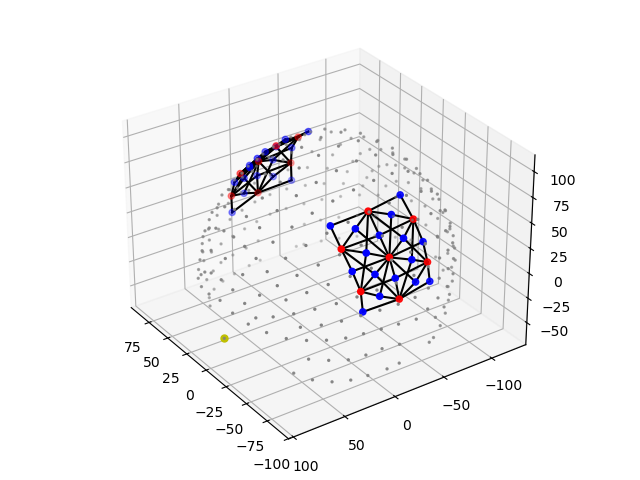

In [6]:
# plot montage
cedalion.plots.plot_montage3D(rec["amp"], rec.geo3d)

## Load and Display Photogrammetric Scan 

In [7]:
# load scan
scan = cedalion.io.read_einstar_obj(PG_DATADIR)

# find label stickers on the scan
PGprocessor = cedalion.geometry.photogrammetry.processors.ColoredStickerProcessor(
    colors={
        "O" : ((0.11, 0.21, 0.7, 1)), # (hue_min, hue_max, value_min, value_max)
        #"L" : ((0.25, 0.37, 0.35, 0.6))
    }
)
sticker_centers, normals, details = PGprocessor.process(scan, details=True)


[[ 172.506348  168.70253   570.348572]
 [-247.762009  317.902527  310.348602]
 [ 150.027954   86.302536  570.348572]
 ...
 [ 146.47406   217.239182  493.978607]
 [ 145.855286  217.494583  493.578003]
 [ 145.55806   217.509079  493.342957]]
[[153.826904 253.747421 570.348572]
 [152.226929 254.987106 570.348572]
 [151.426941 255.54277  570.348572]
 ...
 [147.931213 179.410263 446.350281]
 [146.85408  180.071243 446.188019]
 [148.198898 179.035706 446.32309 ]]
O (0.11, 0.21, 0.7, 1)
[0.0510395  0.14355842 0.31750923 0.23611748 0.22337348 0.08577019
 0.39936103 0.04708672 0.07661262 0.07265083 0.05569695 0.00931695
 0.12417121 0.07045661 0.07032844 0.06201362 0.10816765 0.32977119
 0.42587471 0.16597114 0.04891487 0.09873909 0.1192115  0.08660943
 0.30585273 0.08912666 0.01004768 0.00281426 0.15766289 0.15507026
 0.09780144 0.48502082 0.21359321 0.02668098 0.32618171 1.33795525
 0.08177803 0.00747566 0.34095757 0.20767707 0.32979805 2.35374077
 0.08937995 0.7041256  0.45662605 0.32529975 0

### Optodes can be manually removed or added, if not all were found

In [8]:
visualizer = cedalion.plots.OptodeSelector(scan, sticker_centers, normals)
visualizer.plot()
visualizer.enable_picking()
cedalion.plots.plot_surface(visualizer.plotter, scan, opacity=1.0)
visualizer.plotter.show()

Widget(value='<iframe src="http://localhost:62536/index.html?ui=P_0x215045b1490_1&reconnect=auto" class="pyvis…

After selecting all optodes, update sticker_centers and normals:

In [9]:
sticker_centers = visualizer.points
normals = visualizer.normals if visualizer.normals is not None else normals

## Optode projection and landmark selection

In [10]:
optode_length = 22.6 * cedalion.units.mm

scalp_coords = sticker_centers.copy()
mask_optodes = sticker_centers.group == 'O'
scalp_coords[mask_optodes] = sticker_centers[mask_optodes] - optode_length*normals[mask_optodes]
#display(scalp_coords)

plt = pv.Plotter()
cedalion.plots.plot_surface(plt, scan, opacity=0.3)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="g")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

Widget(value='<iframe src="http://localhost:62536/index.html?ui=P_0x21505224a10_2&reconnect=auto" class="pyvis…

### Landmark selection

In [11]:
plt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(plt, scan, opacity=1.0, pick_landmarks = True)
plt.show(interactive = True)

Widget(value='<iframe src="http://localhost:62536/index.html?ui=P_0x215045b4bd0_3&reconnect=auto" class="pyvis…

### Get landmarks from the plot
Call *get_landmarks* from the previous cell and write into xarray
* 1st value - coordinates of picked landmarks
* 2nd - labels of corresponding landmarks

In [12]:
import tkinter as tk
from tkinter import messagebox

landmark_coordinates, landmark_labels = get_landmarks()

# write into Xarray
landmarks = xr.DataArray(
    np.vstack(landmark_coordinates),
    dims=["label", "digitized"],
    coords={
        "label": ("label", landmark_labels),
        "type": ("label", [cdc.PointType.LANDMARK]*5),
        "group": ("label", ["L"]*5),
    },
).pint.quantify("mm")


display(landmarks)

Magnitude,[[68.05469236557448 58.726783758140584 594.1588970613428] [-8.625007627637444 240.87763536517468 518.4583207981208] [38.35113974103024 106.75769338682105 489.598502904567] [176.55397718758354 170.10389994277983 533.3296375649993] [48.454119818146665 174.79465785135338 625.198088614871]]
Units,millimeter


### Load montage info from snirf file and find transformation between  montage to landmarks

In [13]:
montage_elements = rec.geo3d
montage_elements = montage_elements.rename({"pos" : "aligned"})
#montage_elements
# find transformation between landmarks and montage elements
trafo = cedalion.geometry.registration.register_trans_rot(landmarks, montage_elements)

# apply the transformation to the montage elements
filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo)


ValueError: cannot rename 'pos' because it is not a variable or dimension in this dataset

### Coregistration: find and assign optode labels of scalp coordinates

In [ ]:
scalp_coords = sticker_centers.copy()

# iterative closest point registration
idx = cedalion.geometry.registration.icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 100) 
# extract labels for detected optodes
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

# write labels to scalp_coords
scalp_coords = scalp_coords.assign_coords(label=labels)


## visualize results
# Green points represent optode centers
# Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)
plt = pv.Plotter()
cedalion.plots.plot3d(None, scan.mesh, filtered_montage_elements_t, None, plotter = plt) 
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="green", show_labels = True)
plt.show(interactive = True)


### Update geo3D coordinates for the headmodel 

Transform coordinates to headmodel coordinates and snap to surface. Save them.

In [ ]:
# update geo3D with accurate optode scalp positions and landmarks
geo3Dscan = geo3d_from_scan(scalp_coords, landmarks)
# save geo3Dscan to disk via snirf by using a copy of rec
rectmp = rec
rectmp.geo3d = geo3Dscan

# save data
SAVEDATA = False
if SAVEDATA:
    cedalion.io.write_snirf(TEMP_DATADIR + datafull, rectmp)

# Preprocess Finger Tapping Data

In [14]:
## Prune with SNR threshold
snr_thresh = 10 # dB
snr, rec.masks["snr_mask"] = quality.snr(rec["amp"], snr_thresh)
# prune channels using the masks and the operator "all", which will keep only channels that pass all three metrics
rec["amp_pruned"], drop_list = quality.prune_ch(rec["amp"], [rec.masks["snr_mask"]], "all")

# Convert to OD
rec["od"] = cedalion.nirs.int2od(rec["amp"])

## find and remove movement artifacts
# define parameters for motion artifact detection. We follow the method from Homer2/3: "hmrR_MotionArtifactByChannel" and "hmrR_MotionArtifact".
t_motion = 0.5*units.s  # time window for motion artifact detection
t_mask = 1.0*units.s    # time window for masking motion artifacts (+- t_mask s before/after detected motion artifact)
stdev_thresh = 4.0      # threshold for standard deviation of the signal used to detect motion artifacts. Default is 50. We set it very low to find something in our good data for demonstration purposes.
amp_thresh = 5.0        # threshold for amplitude of the signal used to detect motion artifacts. Default is 5.
# to identify motion artifacts with these parameters we call the following function
rec.masks["ma_mask"] = quality.id_motion(rec["od"], t_motion, t_mask, stdev_thresh, amp_thresh)
rec.masks["ma_mask"], ma_info = quality.id_motion_refine(rec.masks["ma_mask"], 'by_channel')
# THIS IS WHERE WE WOULD APPLY SPLINE SG
# XXXXXXXXXXXXXXX
# XXXXXXXXXXXXXXX


# Convert to  HbO/HbR
dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
rec["conc"] = cedalion.nirs.beer_lambert(rec["amp_pruned"], rec.geo3d, dpf)


# lowpass od concentration data for image recon later
rec["od_freqfilt"] = rec["od"].cd.freq_filter(
        fmin=0.01, fmax=0.5, butter_order=4
    )
# lowpass filter concentration data for block averages below
rec["conc_freqfilt"] = rec["conc"].cd.freq_filter(
        fmin=0.01, fmax=0.5, butter_order=4
    )


mask collapsed to channel dimension


# Plot a channel for quality control

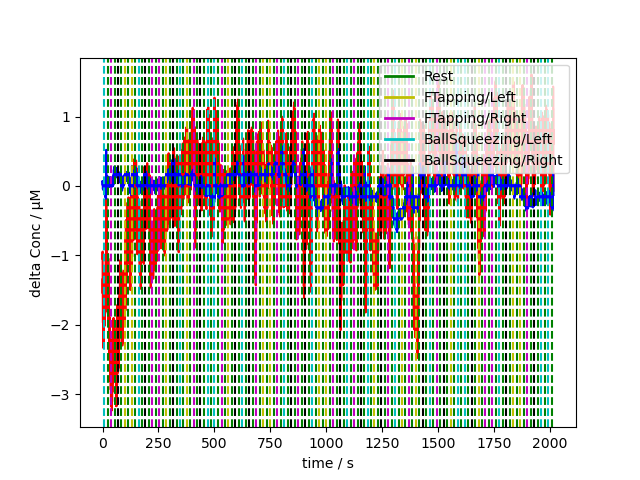

In [15]:
p.figure()
p.plot(rec["conc"].time, rec["conc"].sel(channel="S1D2", chromo="HbO"), "r-", label="HbO")
p.plot(rec["conc"].time, rec["conc"].sel(channel="S1D2", chromo="HbR"), "b-", label="HbR")

# Adding vertical stimulus lines
clr = {'Rest': 'g', 'FTapping/Left': 'y', 'FTapping/Right': 'm', 'BallSqueezing/Left': 'c', 'BallSqueezing/Right': 'k'}
for idx, onset in enumerate(rec.stim['onset']):
    # Use the index to get the corresponding element in the 'duration' column
    type = rec.stim.at[idx, 'trial_type']
    p.axvline(x=onset, color=clr[type], linestyle='--', label=type)

p.xlabel("time / s")
p.ylabel("delta Conc / µM")


# Defining custom legend handles and labels
custom_handles = [
    p.Line2D([0], [0], color='g', lw=2, label='Rest'),
    p.Line2D([0], [0], color='y', lw=2, label='FTapping/Left'),
    p.Line2D([0], [0], color='m', lw=2, label='FTapping/Right'),
    p.Line2D([0], [0], color='c', lw=2, label='BallSqueezing/Left'),
    p.Line2D([0], [0], color='k', lw=2, label='BallSqueezing/Right'),
]

# Adding the custom legend
p.legend(handles=custom_handles, loc='upper right')



# Plot Block Averages

mask collapsed to channel dimension


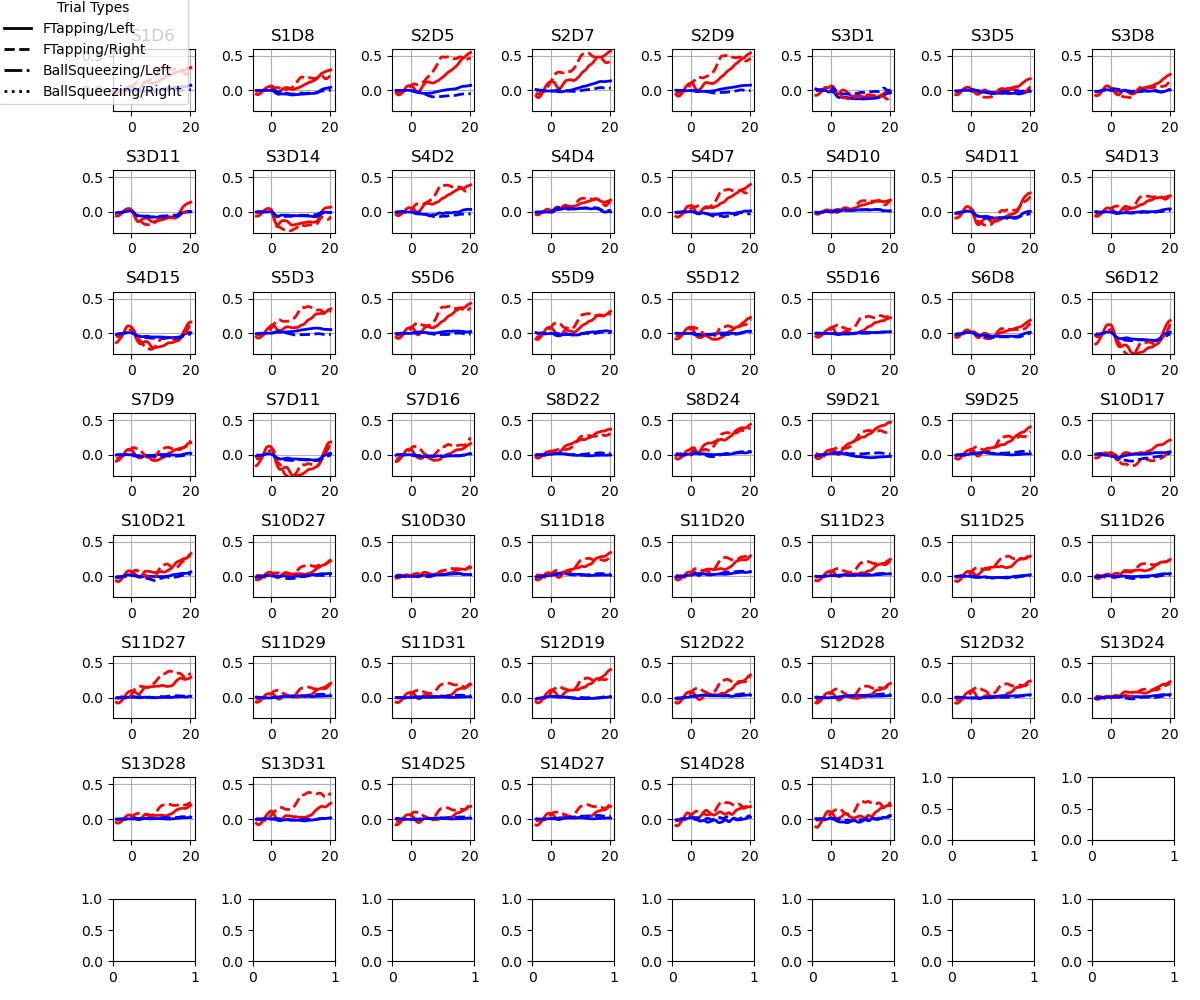

In [17]:
## keep only subset of long channels
sd_threshs = [2, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep
ch_dist, rec.masks["sd_mask"] = quality.sd_dist(rec["conc_freqfilt"], rec.geo3d, sd_threshs)
rec["conc_freqfilt_LD"], masked_elements = xrutils.apply_mask(rec["conc_freqfilt"], rec.masks["sd_mask"], "drop", "channel")


# segment data into epochs
rec["cfepochs"] = rec["conc_freqfilt_LD"].cd.to_epochs(
        rec.stim,  # stimulus dataframe
        ["FTapping/Left", "FTapping/Right"],#, "BallSqueezing/Left", "BallSqueezing/Right"], # select events. do not use "Rest"
        before=5*units.s,  # seconds before stimulus
        after=20*units.s,  # seconds after stimulus
)

# calculate baseline
baseline_conc = rec["cfepochs"].sel(reltime=(rec["cfepochs"].reltime < 0)).mean("reltime")
# subtract baseline
rec["conc_epochs_blcorrected_LD"] = rec["cfepochs"] - baseline_conc

# group trials by trial_type. For each group individually average the epoch dimension
rec["blockaverage_conc"] = rec["conc_epochs_blcorrected_LD"] .groupby("trial_type").mean("epoch")

# Define line styles and trial types
line_styles = ["-", "--", "-.", ":"]
trial_types = ["FTapping/Left", "FTapping/Right", "BallSqueezing/Left", "BallSqueezing/Right"]

# Create custom legend handles
legend_handles = [Line2D([0], [0], color='k', lw=2, ls=ls, label=tt) for ls, tt in zip(line_styles, trial_types)]

# plot single channels
noPlts2 = int(np.ceil(np.sqrt(len(rec["blockaverage_conc"].channel))))
f, ax = p.subplots(noPlts2, noPlts2, figsize=(12, 10))
ax = ax.flatten()
for i_ch, ch in enumerate(rec["blockaverage_conc"].channel):
    for ls, trial_type in zip(line_styles, rec["blockaverage_conc"].trial_type):
        ax[i_ch].plot(
            rec["blockaverage_conc"].reltime,
            rec["blockaverage_conc"].sel(chromo="HbO", trial_type=trial_type, channel=ch),
            "r",
            lw=2,
            ls=ls,
        )
        ax[i_ch].plot(
            rec["blockaverage_conc"].reltime,
            rec["blockaverage_conc"].sel(chromo="HbR", trial_type=trial_type, channel=ch),
            "b",
            lw=2,
            ls=ls,
        )
    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-0.3, 0.6)

# Add the legend to the first subplot
ax[0].legend(handles=legend_handles, title="Trial Types", loc='lower right')
p.tight_layout()

p.show() 

# DOT Image Reconstruction

## Optode Registration
Align the photogrammetrically registered optode positions with the scalp surface

In [ ]:
LOAD_SCANCOORDS = True
# if we did the photogrammetric coregistration in a previous session and saved the results, load them here from our temp snirf file
if LOAD_SCANCOORDS:
    recordtmp = cedalion.io.read_snirf(TEMP_DATADIR + datafull)
    rectmp = record[0]
    geo3Dscan = rectmp.geo3d

geo3dscan_snapped_ijk = head.align_and_snap_to_scalp(geo3Dscan)

plt = pv.Plotter(notebook=True, off_screen=False)
cedalion.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, geo3dscan_snapped_ijk, show_labels = True)
plt.show(interactive = True)

In [23]:
recordtmp = cedalion.io.read_snirf(TEMP_DATADIR + datafull)
recordtmp

[]

## Simulate light propagation with MCX or NIRFASTER

In [ ]:
fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3dscan_snapped_ijk, rec._measurement_lists["amp"])

USE_CACHED = True
RUN_PACKAGE = 'NIRFASTer' # or 'MCX'

if USE_CACHED:
    fname = FP_DATADIR+'AvL_fluence.pickle.gz'
    with gzip.GzipFile(fname) as fin:        
        fluence_all, fluence_at_optodes = pickle.load(fin)
else:
    if RUN_PACKAGE == 'MCX':
        fluence_all, fluence_at_optodes = fwm.compute_fluence_mcx()
    elif RUN_PACKAGE == 'NIRFASTer':
        fluence_all, fluence_at_optodes = fwm.compute_fluence_nirfaster()
    # save computed fluence data (xarrays) to disk to avoid having to re-run each time
    file = gzip.GzipFile(FP_DATADIR+'AvL_fluence.pickle.gz', 'wb')
    file.write(pickle.dumps([fluence_all, fluence_at_optodes]))
    file.close()

## Plot fluence

To illustrate the tissue probed by light travelling from a source to the detector two fluence profiles need to be multiplied. 

In [ ]:
time.sleep(1)

plt = pv.Plotter()

f = fluence_all.loc["S1", 760].values * fluence_all.loc["D8",760].values
f[f<=0] = f[f>0].min()
f = np.log10(f)
vf = pv.wrap(f)

plt.add_volume(
    vf,
    log_scale=False, 
    cmap='plasma_r',
    clim=(-10,0),
)
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_labeled_points(plt, geo3dscan_snapped_ijk, show_labels = True)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [-300,30, 150]
plt.camera.focal_point = cog 
plt.camera.up = [0,0,1] 

plt.show()

## Inverse Problem

### Calculate the sensitivity matrices

The sensitivity matrix describes the effect of an absorption change at a given surface vertex in the OD recording in a given channel and at given wavelength. The coordinate `is_brain` holds a mask to distinguish brain and scalp voxels.

The sensitivity `Adot` has shape (nchannel, nvertex, nwavelenghts). To solve the inverse problem we need a matrix that relates OD in channel space to absorption in image space. Hence, the sensitivity must include the extinction coefficients to translate between OD and concentrations. Furthermore, channels at different wavelengths must be  stacked as well vertice and chromophores into new dimensions (flat_channel, flat_vertex):

$$ \left( \begin{matrix} OD_{c_1, \lambda_1} \\ \vdots \\ OD_{c_N,\lambda_1} \\ OD_{c_1,\lambda_2} \\ \vdots \\ OD_{c_N,\lambda_2} \end{matrix}\right) = A \cdot
\left( \begin{matrix} \Delta c_{v_1, HbO} \\ \vdots \\ \Delta c_{v_N, HbO} \\ \Delta c_{v_1, HbR} \\ \vdots \\ \Delta c_{v_N, HbR} \end{matrix}\right) $$

In [ ]:
# compute sensitivity matrix
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)
Adot_stacked = fwm.compute_stacked_sensitivity(Adot)
# Invert the matrix
B = pseudo_inverse_stacked(Adot_stacked)
nvertices = B.shape[0]//2
B = B.assign_coords({"chromo" : ("flat_vertex", ["HbO"]*nvertices  + ["HbR"]* nvertices)})
B = B.set_xindex("chromo")

### Calculate average concentration changes on the cortex

In [ ]:
od_epochs = rec["od_freqfilt"].cd.to_epochs(
        rec.stim, # stimulus dataframe
        ["FTapping/Left", "FTapping/Right", "BallSqueezing/Left", "BallSqueezing/Right"],  # select events
        before=5, # seconds before stimulus
        after=20  # seconds after stimulus
)

# calculate baseline
od_baseline = od_epochs.sel(reltime=(od_epochs.reltime < 0)).mean("reltime")
# subtract baseline
od_epochs_blcorrected = od_epochs - od_baseline

# group trials by trial_type. For each group individually average the epoch dimension
od_blockaverage = od_epochs_blcorrected.groupby("trial_type").mean("epoch")

#the optical density has shape (nchannel, nwavelength, time) -> stack channel and wavelength dimension into new flat_channel dimension
od_stacked = od_blockaverage.stack({"flat_channel" : ["wavelength", "channel"]})

# calculate the concentration on cortex by multiypling with the inverted sensitivity matrix
dC = B @ od_stacked

## Plot results of image recon

Using functionality from pyvista and VTK plot the concentration changes on the brain surface

In [ ]:
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)

# plot brain surface

for chromophore in ["HbO", "HbR"]:
    for view in ["left_hemi", "right_hemi"]:
        for trial_type,gif_fname in [("FTapping/Left", "FTapping-Left"),
                                    ("FTapping/Right", "FTapping-Right"),
                                    ("BallSqueezing/Left", "BallSqueezing-Left"),
                                    ("BallSqueezing/Right", "BallSqueezing-Right")]:

            hb = dC.sel(chromo=chromophore, trial_type=trial_type).pint.dequantify() / 1e-6 # FIXME unit handling
            hb_brain = hb[(Adot.is_brain == True).values,:]

            ntimes = hb.sizes["reltime"]

            b = cdc.VTKSurface.from_trimeshsurface(head.brain)
            b = pv.wrap(b.mesh)
            b["reco_hb"] = (hb_brain[:,0] - hb_brain[:,0])

            plt = pv.Plotter()

            plt.add_mesh(
                b,
                scalars="reco_hb",
                cmap='seismic', # 'gist_earth_r', 
                clim=(-0.3,0.3),
                scalar_bar_args = {"title" : "HbO / µM"},
                smooth_shading=True
            )

            cedalion.plots.plot_labeled_points(plt, geo3dscan_snapped_ijk)


            tl = lambda tt : f"{trial_type} {chromophore} rel. time: {tt:.3f} s"
            time_label = plt.add_text(tl(0))

            cog = head.brain.vertices.mean("label").values
            if view == "left_hemi":
                plt.camera.position = cog + [-400,0,0]
            else:
                plt.camera.position = cog + [0,0,400]
            plt.camera.focal_point = cog 
            plt.camera.up = [0,0,1] 
            plt.reset_camera()

            plt.open_gif(gif_fname+"_"+chromophore+"_"+view+".gif")

            for i in range(0,ntimes,3):
                b["reco_hb"] = (hb_brain[:,i] - hb_brain[:,0])
                time_label.set_text("upper_left", tl(hb_brain.reltime[i]))

                plt.write_frame()

            plt.close()

In [ ]:
display(Image(data=open("FTapping-Right_HbO_left_hemi.gif",'rb').read(), format='png'))
display(Image(data=open("FTapping-Right_HbR_left_hemi.gif",'rb').read(), format='png'))

## WIP! Training a LDA classifier with Scikit-Learn
For this example we use a very simple non-sophisticated approach. This section is currently WIP and probably flawed

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
# start with the frequency-filtered, epoched and baseline-corrected concentration data
# discard the samples before the stimulus onset
epochs = rec["conc_epochs_blcorrected_LD"].sel(reltime=rec["conc_epochs_blcorrected_LD"].reltime >=0)
# strip units. sklearn would strip them anyway and issue a warning about it.
epochs = epochs.pint.dequantify()

# need to manually tell xarray to create an index for trial_type
epochs = epochs.set_xindex("trial_type")
# pool finger tapping and ball squeezing trial types into only "left" vs "right"

#calculate the mean amplitude in the interval 8-15s after stimulus onset as a feature
epochs_meanfeature = epochs.sel(reltime=slice(8,15)).mean("reltime")
# stack the features of all channels and chromophores into a single feature vector 
X = epochs_meanfeature.stack(features=["chromo", "channel"])
#display(X)

In [ ]:

# reduce the set of trials to include only the desired trial types, here Finger Tapping
ttype_des = ["FTapping/Left", "FTapping/Right"] # "BallSqueezing/Left", "BallSqueezing/Right"
X_des = X.where(X.trial_type.isin(ttype_des), drop=True)
display(X_des.sel(channel="S4D6", chromo ="HbO"))

### Scatter plot of an example feature: HbO at Channel S4D6 for both trials

In [ ]:
import matplotlib.pyplot as plt

# Select the data for HbO and HbR
HbO_data_l = X_des.sel(channel="S4D6", chromo="HbO", trial_type="FTapping/Left")
HbO_data_r = X_des.sel(channel="S4D6", chromo="HbO", trial_type="FTapping/Right")

# Extract the values to be plotted
HbO_data_lvs = HbO_data_l.values
HbO_data_rvs = HbO_data_r.values

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(HbO_data_lvs, HbO_data_rvs, c='blue', alpha=0.5, label="HbO L vs HbO R")
plt.plot([-0.4, 0.8], [-0.4, 0.8], 'r--', label='y = x')

# Add labels and title
plt.xlabel("HbO Values L")
plt.ylabel("HbO Values R")
plt.title("Scatter Plot of HbO L vs R (Channel: S4D6)")
plt.legend()

# Show the plot
plt.show()

In [ ]:
# encode the trial types and train classifier
y = xr.apply_ufunc(LabelEncoder().fit_transform, X.trial_type)

# Initialize the classifier
classifier = LinearDiscriminantAnalysis(n_components=1)

# Set up 10-fold cross-validation
kf = StratifiedKFold(n_splits=10)

# Perform cross-validation
cross_val_scores = cross_val_score(classifier, X, y, cv=kf)

# Print the accuracy for each fold
print("Cross-validation accuracy scores for each fold:")
for i, score in enumerate(cross_val_scores, start=1):
    print(f"Fold {i}: {score:.4f}")

# Print the mean accuracy across all folds
print(f"\nMean accuracy across all folds: {cross_val_scores.mean():.4f}")

In [ ]:
f, ax = p.subplots(1, 2, figsize=(12, 3))

for trial_type, c in zip(["FTapping/Left", "FTapping/Right"], ["r", "g"]):
    kw = dict(alpha=0.5, fc=c, label=trial_type)
    ax[0].hist(classifier.decision_function(X_train.sel(trial_type=trial_type)), **kw)
    ax[1].hist(classifier.decision_function(X_test.sel(trial_type=trial_type)), **kw)

ax[0].set_xlabel("LDA score")
ax[1].set_xlabel("LDA score")
ax[0].set_title("train")
ax[1].set_title("test")
ax[0].legend(ncol=1, loc="upper left")
ax[1].legend(ncol=1, loc="upper left");